In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import plot_spatiotemporal_data, tight_kwargs

C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


params torch.Size([4000, 4])


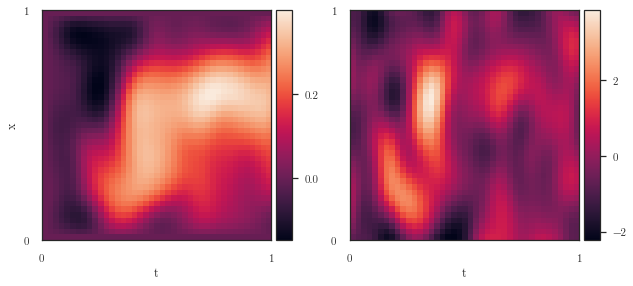

In [3]:
ntest = 50

dataset = ReactionDiffusion('../../../data', nn_format=True, max_n=4000, ntest=ntest)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)

batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)
C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


params torch.Size([50, 4])
params torch.Size([50, 4])


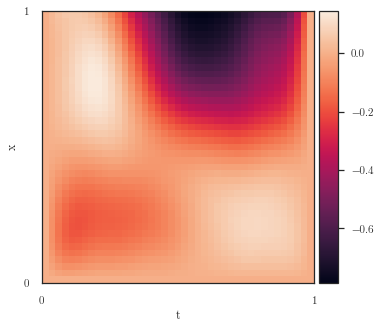

In [4]:
dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 8
width = 32
in_channels = 3


In [5]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

7087726


In [24]:
trainer.train(10);

Epoch 021/030 - Loss: -1.19 (-1.27 -1.21 -1.28 0.02 0.02)
Epoch 022/030 - Loss: -1.26 (-1.19 -1.27 -1.20 0.01 0.01)
Epoch 023/030 - Loss: -1.24 (-1.30 -1.25 -1.31 0.01 0.01)
Epoch 024/030 - Loss: -1.33 (-1.33 -1.34 -1.35 0.01 0.01)
Epoch 025/030 - Loss: -1.31 (-1.26 -1.32 -1.28 0.01 0.01)
Epoch 026/030 - Loss: -1.28 (-1.30 -1.29 -1.31 0.01 0.01)
Epoch 027/030 - Loss: -1.29 (-1.21 -1.31 -1.22 0.02 0.01)
Epoch 028/030 - Loss: -1.24 (-1.25 -1.25 -1.26 0.02 0.01)
Epoch 029/030 - Loss: -1.31 (-1.36 -1.32 -1.37 0.01 0.01)
Epoch 030/030 - Loss: -1.38 (-1.40 -1.39 -1.41 0.01 0.01)


In [25]:
from torch.nn.functional import softplus

def show_result(model, loader, weird=False):
    x, y, params = next(iter(loader))
    out, params_out = model(x)

    num_t = x.shape[1]
    num_x = x.shape[2]
    print(num_t, num_x)
    if not weird:
        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x).t(),
                y[0, ..., 0].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )
    else:
        a = np.zeros((41, 41, 4))
        a[:, :, 0] = out[0, ..., 0].detach()
        a[:, :, 0] = (a[:, :, 0] - a[:, :, 0].min()) / (a[:, :, 0].max() - a[:, :, 0].min())
        a[:, :, 3] = out[0, ..., 1].detach()
        a[:, :, 3] = 1-(a[:, :, 3] - a[:, :, 3].min()) / (a[:, :, 3].max() - a[:, :, 3].min())
        # print(a)
        # a = out[0, ..., 0].detach()
        plt.imshow(a, origin='lower', extent=extent)
        # plt.imshow(out[0, ..., 1].detach(), origin='lower', extent=extent)
        plt.colorbar()
    out = out.squeeze()
    y_target = y.squeeze()
    print(params_out[0].detach(), params[0])
    print(F.mse_loss(out[...,0], y_target))
    # from lafomo.utilities.torch import smse, q2
    # print(y.shape, f_mean_test.shape)
    # print(smse(y_target, f_mean_test).shape)

41 41
tensor([0.2380, 0.2975, 0.1783, 0.0209]) tensor([0.2000, 0.2000, 0.3500, 0.0010])
tensor(0.0540, grad_fn=<MseLossBackward>)


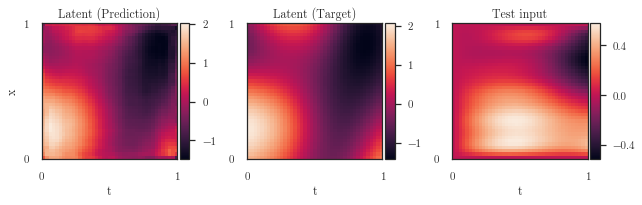

In [26]:
show_result(model, test_loader)

41 41
tensor([0.2380, 0.2975, 0.1783, 0.0209]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.0439, grad_fn=<MseLossBackward>)
81 81
tensor([0.2380, 0.2975, 0.1783, 0.0209]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.0478, grad_fn=<MseLossBackward>)


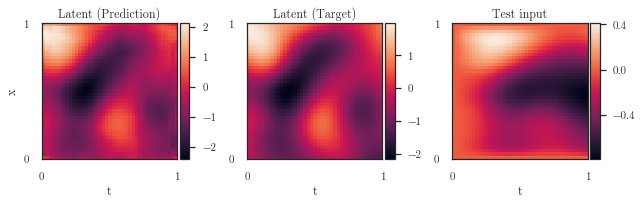

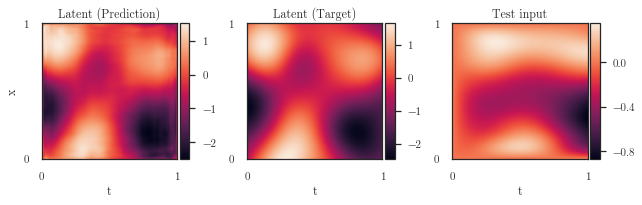

In [27]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

In [29]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics

dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True, nn_format=True)

dataset.train_data[0] = (
    dataset.train_data[0][0],#.permute(1, 0, 2),
    dataset.train_data[0][1],
    dataset.train_data[0][2]
)
print(dataset.train_data[0][0].shape)
dros_loader = DataLoader(dataset.train_data)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxz

params torch.Size([1, 4])
torch.Size([8, 64, 3])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


8 64
tensor([ 18.1867,  36.3184,  30.0530, -40.9921]) tensor([-1., -1., -1., -1.])
tensor(10.9441, grad_fn=<MseLossBackward>)


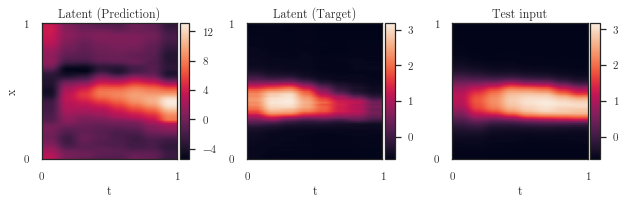

In [30]:
show_result(model, dros_loader)

In [ ]:
torch.save(model.state_dict(), './saved_model3205.pt')

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
# plt.savefig('toy48.pdf', **tight_kwargs)

In [ ]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True, nn_format=True, ntest=0)
print(dataset.train_data[0][0].shape)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)
print(dataset[0][1].shape)
print(dataset.orig_data.shape)
plt.figure()
d = dataset.train_data[0][0][:, :, 0]
x = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
print(x[0][1].shape)
plt.imshow(x[0][1][0].view(41, 41).t(), origin='lower', extent=extent)
plt.figure()
plt.imshow(d.t(), origin='lower', extent=extent)